# EfficientDet Inference 



<table align="left"><td>
  <a target="_blank"  href="https://github.com/google/automl/blob/master/efficientdet/tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/google/automl/blob/master/efficientdet/tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

### 0. Install

In [0]:
#@title
# Install tensorflow and pycocotools
!pip install tensorflow
!pip install pytype
# The default pycocotools doesn't work for python3: https://github.com/cocodataset/cocoapi/issues/49
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

import os
import sys
import tensorflow.compat.v1 as tf

# Download source code.
if "efficientdet" not in os.getcwd():
  !git clone --depth 1 https://github.com/google/automl
  os.chdir('automl/efficientdet')
  sys.path.append('.')
else:
  !git pull

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-o8xi9jsf
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-o8xi9jsf
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=275367 sha256=57f65beb0f3a5c36c27e39929ac93fcc17041bdeab46c3f50e6de9a8c8301aa8
  Stored in directory: /tmp/pip-ephem-wheel-cache-78_8l9qy/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


Already up to date.


In [0]:
MODEL = 'efficientdet-d0'  #@param
# Download checkpoint.
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/{MODEL}.tar.gz
!tar zxf {MODEL}.tar.gz
ckpt_path = os.path.join(os.getcwd(), MODEL)
print('Use model in {}'.format(ckpt_path))

--2020-03-24 08:35:31--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientdet/coco/efficientdet-d0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29040887 (28M) [application/octet-stream]
Saving to: ‘efficientdet-d0.tar.gz.1’

efficientdet-d0.tar 100%[===================>]  27.70M  55.9MB/s    in 0.5s    

2020-03-24 08:35:31 (55.9 MB/s) - ‘efficientdet-d0.tar.gz.1’ saved [29040887/29040887]

Use model in /content/automl/efficientdet/efficientdet-d0


### Inference a single image.

In [0]:
# Image is from issue: https://github.com/google/automl/issues/27
image_url =  'https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png'#@param
image_name = 'img.png' #@param
!wget {image_url} -O img.png

import os
img_path = os.path.join(os.getcwd(), 'img.png')
img_out_dir = os.path.join(os.getcwd(), 'img_out')

if not os.path.exists(img_out_dir):
  os.mkdir(img_out_dir)

# Get the largest of height/width and round to 128.
import PIL
image_size = max(PIL.Image.open(img_path).size)  // 128 * 128

--2020-03-24 08:35:38--  https://user-images.githubusercontent.com/11736571/77320690-099af300-6d37-11ea-9d86-24f14dc2d540.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4080549 (3.9M) [image/png]
Saving to: ‘img.png’

img.png             100%[===================>]   3.89M  --.-KB/s    in 0.07s   

2020-03-24 08:35:39 (59.4 MB/s) - ‘img.png’ saved [4080549/4080549]



In [0]:
min_score_thresh = 0.2  #@param
max_boxes_to_draw = 100  #@param
line_thickness = 4  #@param

# Approach 1: use model_inspect.
# !python model_inspect.py --runmode=infer --model_name={MODEL} --ckpt_path={ckpt_path} --input_image={img_path} --output_image_dir={img_out_dir}

# Approach 2: call InferenceDriver
import inference
tf.reset_default_graph()
driver = inference.InferenceDriver(MODEL, ckpt_path, image_size=image_size)
driver.inference(img_path,
                 img_out_dir,
                 min_score_thresh=min_score_thresh,
                 max_boxes_to_draw=max_boxes_to_draw,
                 line_thickness=line_thickness)

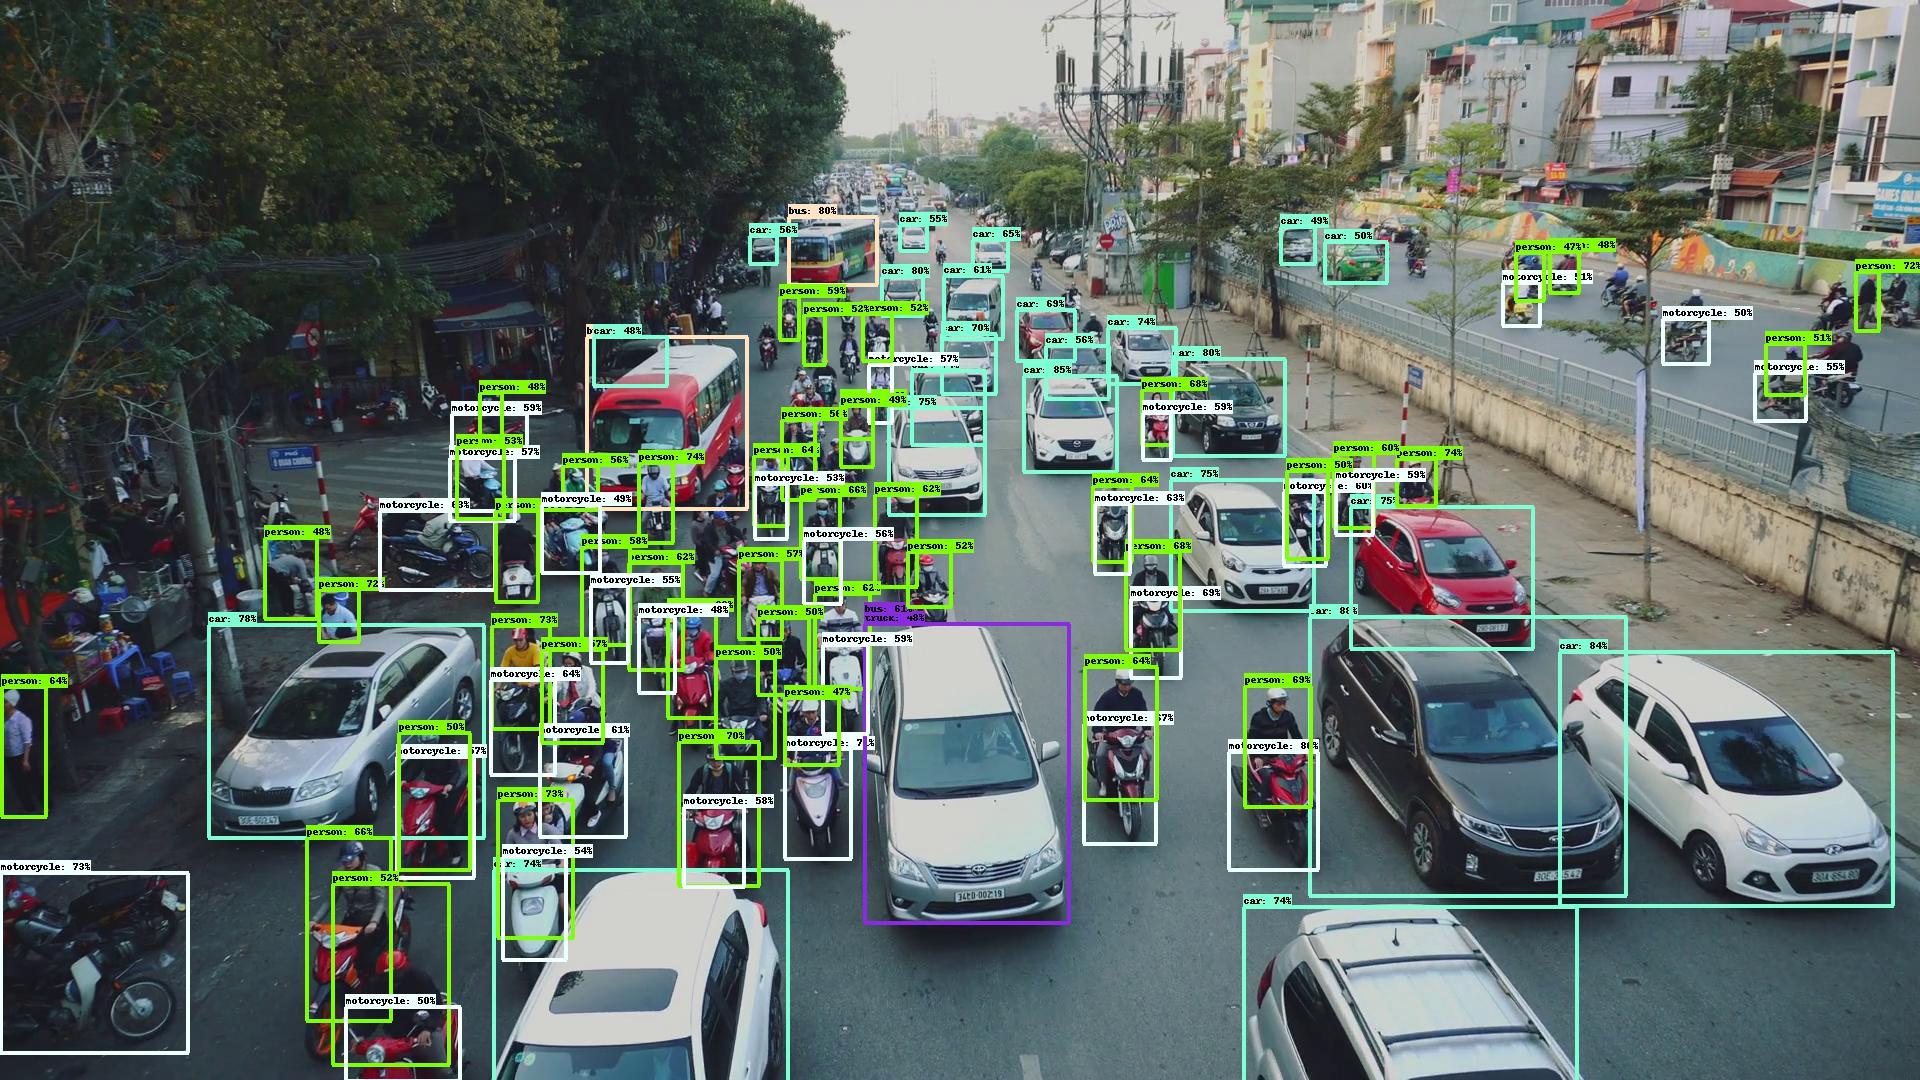

In [15]:
from IPython import display
display.display(display.Image(os.path.join(img_out_dir, '0.jpg')))

## Run COCO Evaluation

In [0]:
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip val2017.zip
!unzip annotations_trainval2017.zip

In [17]:
# Convert to tfrecord
!mkdir tfrecrod
!PYTHONPATH=".:$PYTHONPATH"  python dataset/create_coco_tfrecord.py \
      --image_dir=val2017 \
      --caption_annotations_file=annotations/captions_val2017.json \
      --output_file_prefix=tfrecord/val \
      --num_shards=32

mkdir: cannot create directory ‘tfrecrod’: File exists
I0324 08:38:33.767954 140419897018240 create_coco_tfrecord.py:286] writing to output path: tfrecord/val
I0324 08:38:33.982494 140419897018240 create_coco_tfrecord.py:238] Building caption index.
I0324 08:38:33.988968 140419897018240 create_coco_tfrecord.py:250] 0 images are missing captions.
I0324 08:38:34.036108 140419897018240 create_coco_tfrecord.py:324] On image 0 of 5000
I0324 08:38:34.219093 140419897018240 create_coco_tfrecord.py:324] On image 100 of 5000
I0324 08:38:34.379856 140419897018240 create_coco_tfrecord.py:324] On image 200 of 5000
I0324 08:38:34.539025 140419897018240 create_coco_tfrecord.py:324] On image 300 of 5000
I0324 08:38:34.699924 140419897018240 create_coco_tfrecord.py:324] On image 400 of 5000
I0324 08:38:34.844767 140419897018240 create_coco_tfrecord.py:324] On image 500 of 5000
I0324 08:38:35.005636 140419897018240 create_coco_tfrecord.py:324] On image 600 of 5000
I0324 08:38:35.259866 140419897018240 

In [18]:
# Evalute on validation set
!python main.py --mode=eval  \
    --model_name={MODEL}  --model_dir={ckpt_path}  \
    --validation_file_pattern=tfrecord/val*  \
    --val_json_file=annotations/instances_val2017.json  \
    --hparams="use_bfloat16=false" --use_tpu=False

Instructions for updating:
non-resource variables are not supported in the long term

W0324 08:38:52.020046 140117296494464 module_wrapper.py:139] From main.py:213: The name tf.estimator.tpu.TPUConfig is deprecated. Please use tf.compat.v1.estimator.tpu.TPUConfig instead.


W0324 08:38:52.020277 140117296494464 module_wrapper.py:139] From main.py:218: The name tf.estimator.tpu.InputPipelineConfig is deprecated. Please use tf.compat.v1.estimator.tpu.InputPipelineConfig instead.


W0324 08:38:52.020507 140117296494464 module_wrapper.py:139] From main.py:221: The name tf.estimator.tpu.RunConfig is deprecated. Please use tf.compat.v1.estimator.tpu.RunConfig instead.


W0324 08:38:52.020833 140117296494464 module_wrapper.py:139] From main.py:287: The name tf.estimator.tpu.TPUEstimator is deprecated. Please use tf.compat.v1.estimator.tpu.TPUEstimator instead.

W0324 08:38:52.021766 140117296494464 tpu_context.py:222] eval_on_tpu ignored because use_tpu is False.
Instructions for updating:
If